In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [3]:
class ActionDataset(Dataset):
    """
    This class is the dataset class for the VAE to encode actions into a latent space.
    Therefore we need no label which is in this case an empty tensor
    """
    def __init__(self, annotations_file: str, normalize: bool = False):   
        self.csv = pd.read_csv(annotations_file)
        self.normalize = normalize

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        features = torch.tensor(self.csv.iloc[idx, 1:]).float()
        
        label = torch.tensor([])    
        return features, label


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    

class Decoder(nn.Module):
    def __init__(self, latent_dims, output_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, output_dim)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = self.linear2(z)
        return z
    
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dims)
        self.decoder = Decoder(latent_dims, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(autoencoder, data, epochs=50):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        loss_tensor = torch.tensor([])
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).mean()
            loss_tensor = torch.cat([loss_tensor, torch.tensor([loss.detach()])])
            loss.backward()
            opt.step()
        print(epoch, loss_tensor.mean())
    return autoencoder
    
input_dim = 2
latent_dim = 1
data = DataLoader(ActionDataset(f"../datasets/{input_dim}/train/actions_relative_uniform.csv"), batch_size=128, shuffle=True)
autoencoder = Autoencoder(input_dim, latent_dim).to(device) # GPU
autoencoder = train(autoencoder, data)

0 tensor(0.1825)
1 tensor(0.1307)
2 tensor(0.1107)
3 tensor(0.0991)
4 tensor(0.0926)
5 tensor(0.0887)
6 tensor(0.0862)
7 tensor(0.0827)
8 tensor(0.0793)
9 tensor(0.0765)
10 tensor(0.0741)
11 tensor(0.0745)
12 tensor(0.0702)
13 tensor(0.0679)
14 tensor(0.0668)
15 tensor(0.0652)
16 tensor(0.0647)
17 tensor(0.0629)
18 tensor(0.0625)
19 tensor(0.0607)
20 tensor(0.0610)
21 tensor(0.0599)
22 tensor(0.0588)
23 tensor(0.0574)
24 tensor(0.0581)
25 tensor(0.0567)
26 tensor(0.0551)
27 tensor(0.0538)
28 tensor(0.0544)
29 tensor(0.0543)
30 tensor(0.0533)
31 tensor(0.0523)
32 tensor(0.0520)
33 tensor(0.0518)
34 tensor(0.0502)
35 tensor(0.0494)
36 tensor(0.0499)
37 tensor(0.0485)
38 tensor(0.0490)
39 tensor(0.0514)
40 tensor(0.0480)
41 tensor(0.0469)
42 tensor(0.0466)
43 tensor(0.0472)
44 tensor(0.0480)
45 tensor(0.0457)
46 tensor(0.0455)
47 tensor(0.0457)
48 tensor(0.0460)
49 tensor(0.0451)


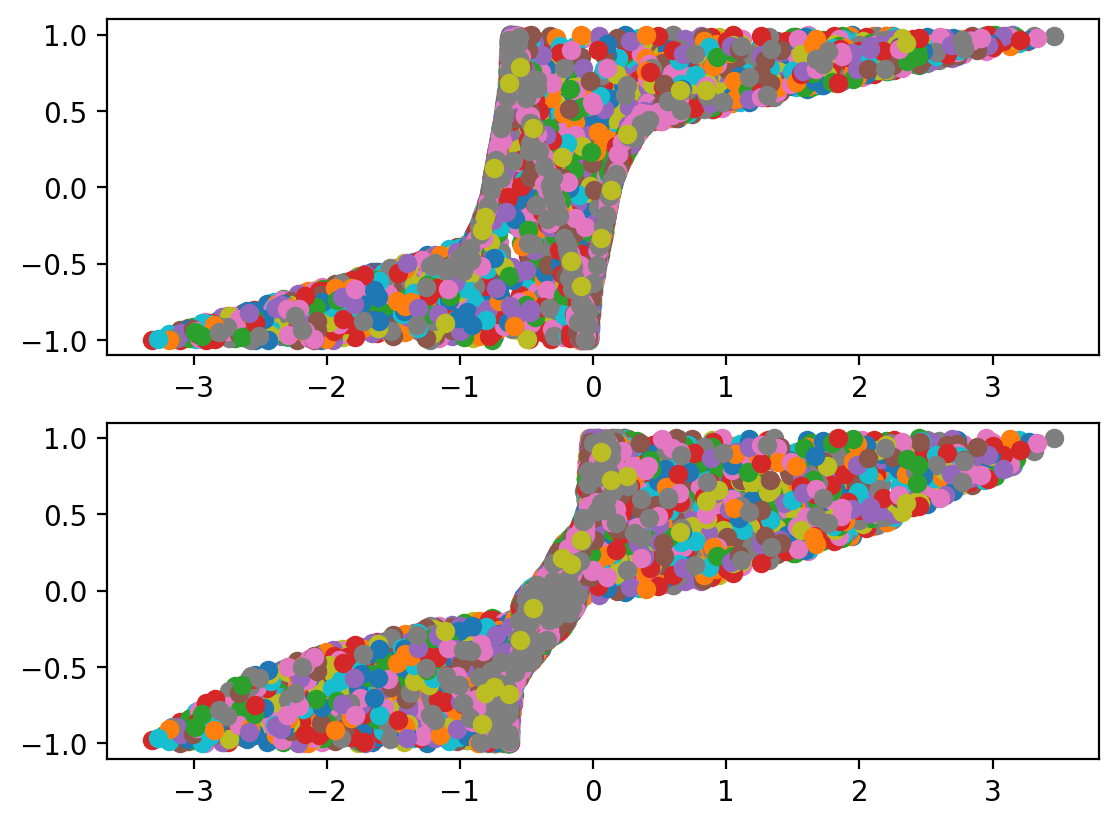

In [16]:
def plot_latent(autoencoder, data, num_batches=100):
    fig, axs = plt.subplots(2, 1)
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))  # out_shape: (batch_size, latent_dim)
        z = z.to('cpu').detach().numpy()
        axs[0].scatter(z, x[:, 0])
        axs[1].scatter(z, x[:, 1])

    plt.show()

plot_latent(autoencoder, data)
        

In [17]:
def plot_reconstructed(autoencoder, sample_size):
    latent_sample = torch.tensor(np.random.uniform(-4, 4, (sample_size, 1)))
    print(latent_sample.size())
    out = autoencoder.decoder(latent_sample)
    fig, axs = plt.subplots(2, 1)
    axs[0].scatter(latent_sample, out[:, 0])
    axs[1].scatter(latent_sample, out[:, 1])
    plt.show()

plot_reconstructed(autoencoder, 200)

torch.Size([200, 1])


RuntimeError: mat1 and mat2 must have the same dtype